In [1]:
# 코드 8-1 모듈 임포트
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                                    Embedding, Flatten, Input, Multiply, Reshape)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# 코드 8-2 모델 입력 차원
img_rows = 28
img_cols = 28
channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터 크기
z_dim = 100

# 데이터셋에 있는 클래스 개수
num_classes = 10

In [3]:
# 코드 8-3 CGAN 생성자
def build_generator(z_dim):

    model = Sequential()
    
    # FC Layer를 이용해 입력을 7 x 7 x 256 텐서로 변환
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    
    # 7 x 7 x 256 에서 14 x 14 x 128 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
    
    model.add(BatchNormalization())
    
    model.add(LeakyReLU(alpha=0.01))
    
    # 14 x 14 x 128 에서 14 x 14 x 68 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding="same"))
    
    model.add(BatchNormalization())
    
    model.add(LeakyReLU(alpha=0.01))
    
    # 14 x 14 x 64에서 28 x 28 x 1 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding="same"))
    
    model.add(Activation("tanh"))
    
    return model

In [4]:
def build_cgan_generator(z_dim):
    
    # 랜덤 잡음 벡터 z
    z = Input(shape=(z_dim, ))
    
    # 조건 레이블 정수 0~9까지 생성자가 만들 숫자
    label = Input(shape=(1, ), dtype="int32")
    
    # 레이블 임베딩: 레이블을 z_dim크기 밀집 벡터로 변환하고 (batch_size, 1, z_dim) 크기 3D 텐서를 만듭니다
    label_embedding = Embedding(num_classes, z_dim, input_length=1)(label)
    
    # 임베딩된 3D 텐서를 펼쳐서 (batch_size, z_dim) 크기 2D 텐서로 바꿉니다.
    label_embedding = Flatten()(label_embedding)
    
    # 터 z와 임베딩의 원소별 곱셈
    joined_representation = Multiply()([z, label_embedding])
    
    generator = build_generator(z_dim)
    
    # 주어진 레이블에 대한 이미지 생성
    conditioned_img = generator(joined_representation)
    
    return Model([z, label], conditioned_img)

In [5]:
# 코드 8-4 CGAN 판별자
def build_discriminator(img_shape):
    
    model = Sequential()
    
    # 28 x 28 x 2 에서 14 x 14 x 64 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=(img_shape[0], img_shape[1], img_shape[2] + 1),
               padding="same"))
        
    model.add(LeakyReLU(alpha=0.01))
        
    # 14 x 14 x 64 에서 7 x 7 x 64 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding="same"))
        
    model.add(LeakyReLU(alpha=0.01))
        
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding="same"))
        
    model.add(LeakyReLU(alpha=0.01))
        
    model.add(Flatten())
    
    model.add(Dense(1, activation="sigmoid"))
    
    return model

In [6]:
def build_cgan_discriminator(img_shape):
    
    # 입력 이미지
    img = Input(shape=img_shape)
    
    # 입력 이미지의 레이블
    label = Input(shape=(1, ), dtype="int32")
    
    # 레이블 임베딩 레이블을 z_dim 크기의 밀집 벡터로 변환하고 (batch_size, 1, 28 x 28 x 1) 크기의 3D 텐서를 만듭니다.
    label_embedding = Embedding(num_classes, np.prod(img_shape), input_length=1)(label)
    
    # 임베딩된 3D 텐서를 펼쳐서 (batch_size, 28 x 28 x 1) 크기의 3D 텐서를 만듭니다.
    label_embedding = Flatten()(label_embedding)
    
    # 레이블 임베딩 크기를 입력 이미지 차원과 동일하게 만듭니다.
    label_embedding = Reshape(img_shape)(label_embedding)
    
    # 이미지와 레이블 임베딩을 연결합니다.
    concatenated = Concatenate(axis=-1)([img, label_embedding])
    
    discriminator = build_discriminator(img_shape)
    
    # 이미지-레이블 쌍을 분류합니다.
    classification = discriminator(concatenated)
    
    return Model([img, label], classification)

In [7]:
# 코드 8-5 CGAN 모델 만들고 컴파일하기
def build_cgan(generator, discriminator):
    
    # 랜덤 잡음 벡터 z
    z = Input(shape=(z_dim, ))
    
    # 이미지 레이블
    label = Input(shape=(1, ))
    
    # 레이블에 맞는 이미지 생성하기
    img = generator([z, label])
    
    classification = discriminator([img, label])
    
    # 생성자 판별자 연결 모델
    model = Model([z, label], classification)
    
    return model

In [8]:
# 판별자 만들고 컴파일하기
discriminator = build_cgan_discriminator(img_shape)
discriminator.compile(loss="binary_crossentropy",
                      optimizer=Adam(learning_rate=0.00001),
                      metrics=["accuracy"])

# 생성자 만들기
generator = build_cgan_generator(z_dim)

# 생성자를 훈련하는 동안 판별자 파라미터를 고정하기
discriminator.trainable = False

# CGAN 모델 만들고 컴파일하기
cgan = build_cgan(generator, discriminator)
cgan.compile(loss="binary_crossentropy",
             optimizer=Adam())

In [9]:
# 코드 8-6 CGAN 훈련 반복
accuracies = []
losses = []

def train(iterations, batch_size, sample_interval):
    
    (X_train, y_train), (_, _) = mnist.load_data() # MNIST 데이터를 로드합니다.
    
    X_train = X_train / 127.5 - 1
    X_train = np.expand_dims(X_train, axis=3)
    
    # 진짜 이미지의 레이블 모두 1
    real = np.ones((batch_size, 1))
    
    # 가짜 이미지의 레이블 모두 0
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        # 진짜 이미지와 레이블로 이루어진 랜덤한 배치를 얻습니다.
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]
        
        # 가짜 이미지의 배치를 생성합니다.
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict([z, labels])
        
        # 판별자를 훈련합니다
        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # 잡음 벡터의 배치를 생성합니다.
        z = np.random.normal(0, 1, (batch_size, z_dim))
        
        # 랜덤한 레이블의 배치를 얻습니다.
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        
        # 생성자를 훈련합니다.
        g_loss = cgan.train_on_batch([z, labels], real)
        
        if (iteration + 1) % sample_interval == 0:
            # 훈련 과정을 출력합니다.
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %.4f]" %
                  (iteration + 1, d_loss[0], 100 * d_loss[1], g_loss))
                  
            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도를 저장
            losses.append((d_loss[0], g_loss))
            accuracies.append(100 * d_loss[1])
            
            sample_images() # 생성한 이미지 샘플을 출력

In [10]:
# 코드 8-7 생성된 이미지 출력하기
def sample_images(image_grid_rows=2, image_grid_columns=5):
    
    # 랜덤한 잡음을 샘플링합니다.
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    # 0 ~ 9 까지의 이미지 레이블을 만듭니다.
    labels = np.arange(0, 10).reshape(-1, 1)
    
    # 랜덤한 잡음에서 이미지를 생성합니다.
    gen_imgs = generator.predict([z, labels])
    
    # 이미지 픽셀값의 스케일을 변환합니다.
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    # 이미지 그리드를 설정합니다.
    fix, axs = plt.subplots(image_grid_rows,
                           image_grid_columns,
                           figsize=(10, 4),
                           sharey=True,
                           sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap="gray")
            axs[i, j].axis("off")
            axs[i, j].set_title("Digit: %d" % labels[cnt])
            cnt += 1

1000 [D 손실: 0.728014, 정확도: 48.44%] [G 손실: 0.5764]
2000 [D 손실: 0.705907, 정확도: 39.06%] [G 손실: 0.6507]
3000 [D 손실: 0.682137, 정확도: 87.50%] [G 손실: 0.6954]
4000 [D 손실: 0.689202, 정확도: 53.12%] [G 손실: 0.7363]
5000 [D 손실: 0.694730, 정확도: 43.75%] [G 손실: 0.6559]
6000 [D 손실: 0.687788, 정확도: 82.81%] [G 손실: 0.6913]
7000 [D 손실: 0.679695, 정확도: 79.69%] [G 손실: 0.7106]
8000 [D 손실: 0.715157, 정확도: 12.50%] [G 손실: 0.6670]
9000 [D 손실: 0.720871, 정확도: 48.44%] [G 손실: 0.5350]
10000 [D 손실: 0.678879, 정확도: 70.31%] [G 손실: 0.7375]
11000 [D 손실: 0.698236, 정확도: 43.75%] [G 손실: 0.6680]
12000 [D 손실: 0.635871, 정확도: 95.31%] [G 손실: 0.7360]
13000 [D 손실: 0.664562, 정확도: 54.69%] [G 손실: 0.7047]
14000 [D 손실: 0.595585, 정확도: 84.38%] [G 손실: 0.7550]
15000 [D 손실: 0.672662, 정확도: 59.38%] [G 손실: 0.6915]
16000 [D 손실: 0.744738, 정확도: 35.94%] [G 손실: 0.6358]
17000 [D 손실: 0.734499, 정확도: 17.19%] [G 손실: 0.6412]
18000 [D 손실: 0.720153, 정확도: 15.62%] [G 손실: 0.6581]
19000 [D 손실: 0.711074, 정확도: 4.69%] [G 손실: 0.6770]
20000 [D 손실: 0.708123, 정확도: 10.94%] [G 손실

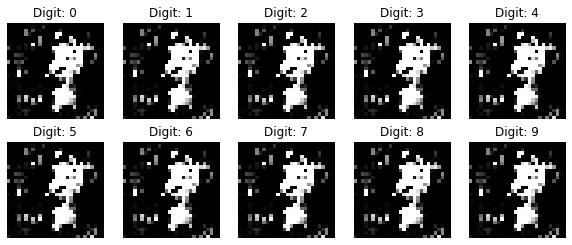

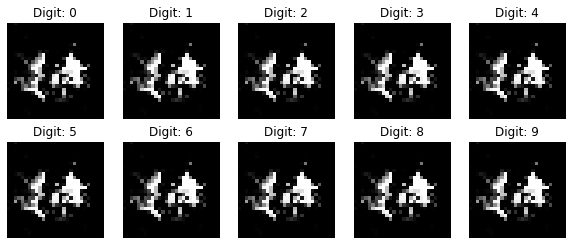

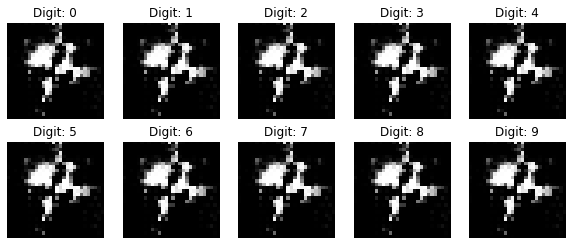

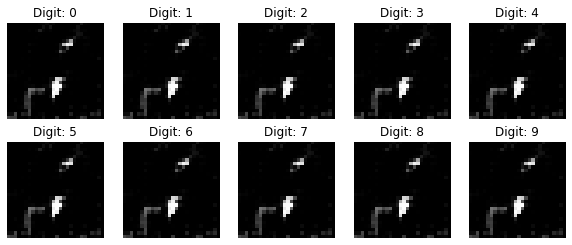

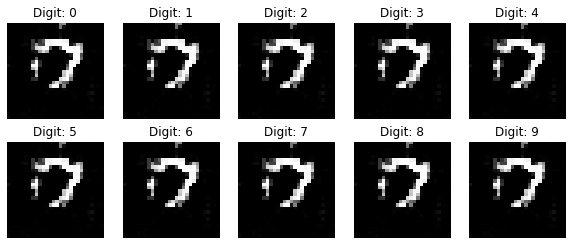

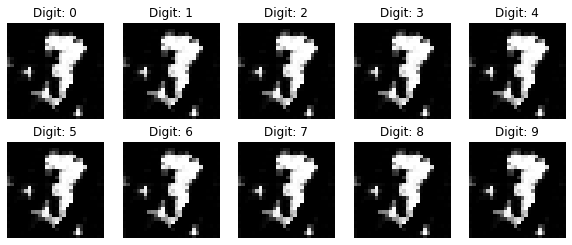

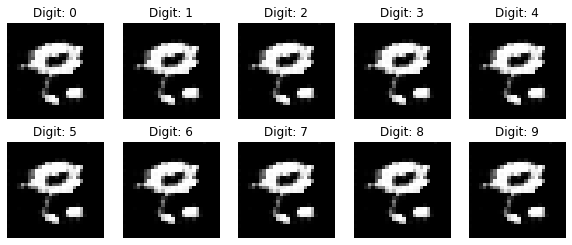

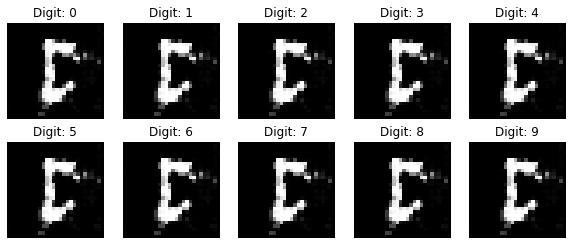

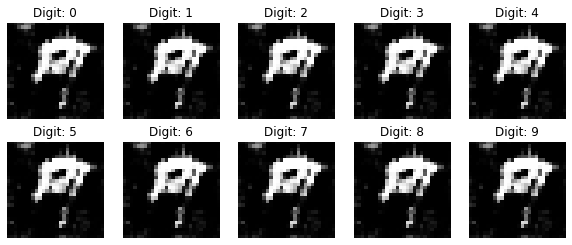

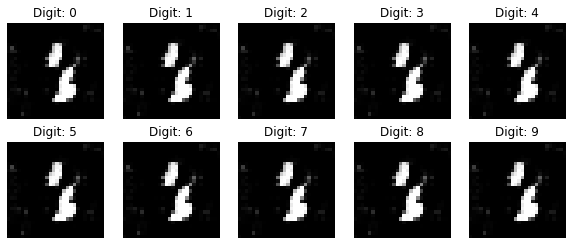

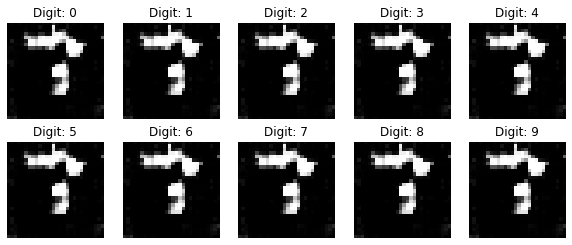

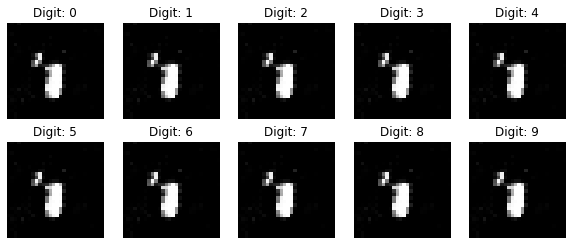

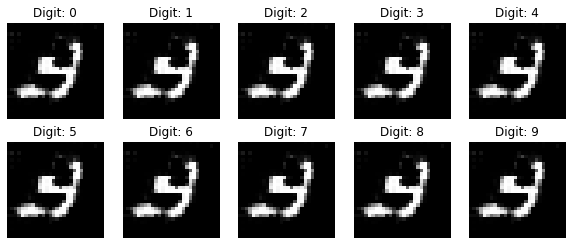

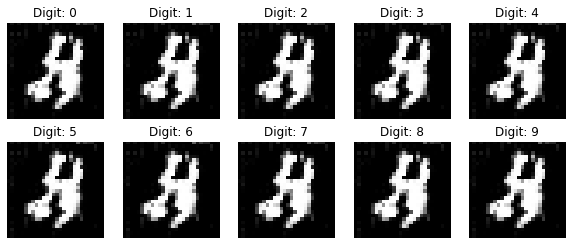

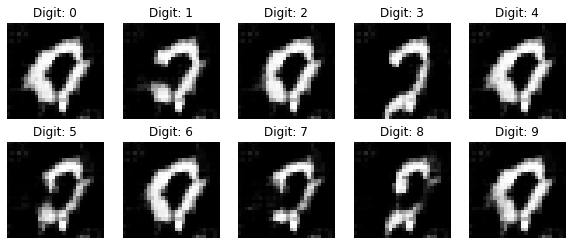

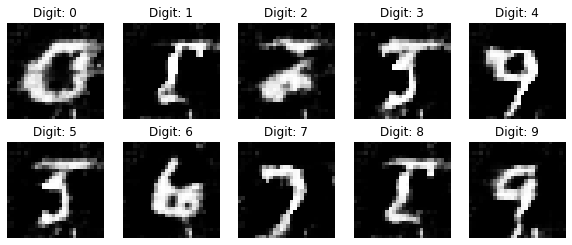

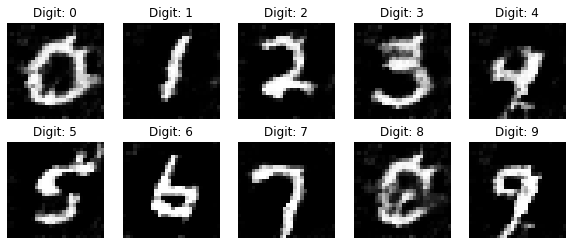

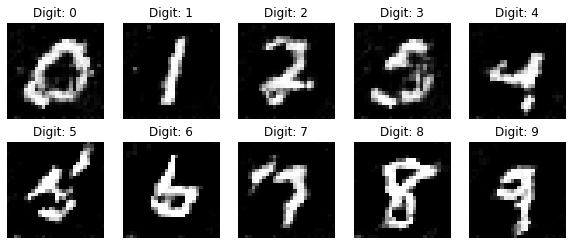

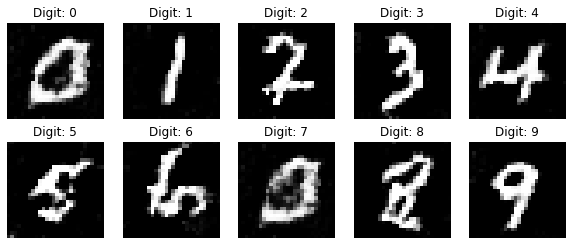

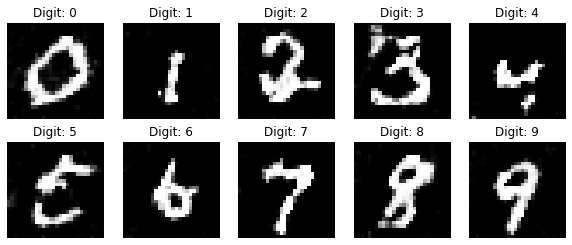

In [11]:
iterations = 20000
batch_size = 32
sample_interval = 1000

train(iterations, batch_size, sample_interval)